**Example maaslin + pathways workflow**

In [34]:
# load the maaslin3 package
library(maaslin3)
# read metadata
meta <- read.csv("../data/metadatav2.txt", sep = '\t', row.names=1)
meta$tbClass <- trimws(meta$tbClass, which = "right")
meta <- meta[meta$savio_id != "", ]
meta$sample <- sub("_R.*\\.fastq\\.gz$", "", meta$savio_id)

meta_other <- read.csv("../data/metadata_v3.txt", sep = '\t')
meta_other <- meta_other[-c(1:6), ]
meta_other$sample <- meta_other$samples
meta_other$samples <- NULL
rownames(meta_other) <- meta_other$sample_id
meta <- rbind(meta, meta_other)
meta$tbClass <- trimws(meta$tbClass, which = "right")

meta <- meta[meta$savio_id != "", ]
meta$sample <- sub("_R.*\\.fastq\\.gz$", "", meta$savio_id)
# read humann pathway abundances 
pathabundance <- read.table(
  '../data/pathabundance_all.tsv',
  sep = '\t', # tab-delimited
  row.names = 1, # first column is row names
  check.names = FALSE, # current sample names are not R-safe, this tells R to not change them
  header = TRUE,  # first row is a header
  comment.char = '', # ignore the top line (starts with #)
   quote='' # ignore quotes
)
colnames(pathabundance) <- sub("_Abundance$", "", colnames(pathabundance))
## check intersection of samples between humann and metadata
cat("only in humann:", length(setdiff(colnames(pathabundance), meta$sample)), "\n")
cat("only in metadata:", length(setdiff(meta$sample, colnames(pathabundance))), "\n")
shared_samples <- intersect(colnames(pathabundance), meta$sample)
cat("shared samples:", length(shared_samples), "\n")
rownames(meta) <- meta$sample
meta <- meta[shared_samples, ]
pathabundance <- pathabundance[, shared_samples]

## pull out cross-taxa and by-taxa pathway abundances ( you could keep these together, but I like to separate them)
cross_taxa <- pathabundance[!grepl("\\|", rownames(pathabundance)),]
by_taxa <- pathabundance[grepl("\\|", rownames(pathabundance)) | rownames(pathabundance) == "UNMAPPED",]
# Normalize  to sum to 1M per sample, fill NAs with 0
cross_taxa <- sweep(cross_taxa, 2, colSums(cross_taxa), '/') * 1000000
cross_taxa[is.na(cross_taxa)] <- 0
by_taxa <- sweep(by_taxa, 2, colSums(by_taxa), '/') * 1000000
by_taxa[is.na(by_taxa)] <- 0
## filter out rows (pathways) that are not found in any samples
by_taxa <- by_taxa[rowSums(by_taxa) != 0, ]
cross_taxa <- cross_taxa[rowSums(cross_taxa) != 0, ]

only in humann: 6 
only in metadata: 27 
shared samples: 245 


**take a look at the values in metadata**

In [37]:
for (col in setdiff(colnames(meta), c("sample_id",'savio_id','sample', 'age'))) {
  cat("Value counts for", col, ":\n")
  print(table(meta[[col]], useNA = "ifany"))
  cat("\n")
}

Value counts for tbClass :

     Confirmed Unclassifiable    Unconfirmed       Unlikely          avium 
            39             11            126             58              1 
       control            mix            mtb          spike 
             3              1              1              5 

Value counts for ntm :

         Negative Positive     <NA> 
      18      213       12        2 

Value counts for sex :

      F   M 
 11 104 130 

Value counts for age_range :

        over1 under1 
    11    195     39 

Value counts for childhood :

           adolescent      early     infant     middle 
        11         11        108         38         77 

Value counts for hiv :

                Exposed HIV-exposed    Negative    Positive 
         24           1           6         182          32 

Value counts for sam :

      N   P 
 11 213  21 

Value counts for underweight :

      N   P 
 11 119 115 



**for the example fit, focusing on confirmed vs unlikely cases in the over1 population**

In [38]:
table(subset(meta, meta$age_range=='over1')[['tbClass']], useNA = "ifany")


     Confirmed Unclassifiable    Unconfirmed       Unlikely 
            29              8            110             48 

In [39]:
table(subset(meta, meta$age_range=='over1')[['underweight']], useNA = "ifany")


  N   P 
100  95 

**example maaslin fit**
- tbClass confirmed vs unconfirmed among children over 1
- control for underweight and sex

In [40]:
## create a directory to store the output
maaslin_dir <- '../data/maaslin_fits/'
if (!dir.exists(maaslin_dir)) dir.create(maaslin_dir, recursive=TRUE)

## pull the rows out of the metadata that we want
meta_sub <- subset(meta, tbClass %in% c("Confirmed", "Unlikely") & age_range == "over1")

## run the cross-taxa pathways
over1_tb <- maaslin3(input_data = cross_taxa, input_metadata = meta_sub,
                    output = paste0(maaslin_dir,'over1_cross_taxa'),
                     formula = "~ tbClass + (1|sex)",
                    normalization = 'TSS', transform = 'LOG', augment=TRUE,
                    standardize=TRUE, max_significance=0.05, median_comparison_abundance=TRUE,
                    median_comparison_prevalence=FALSE, max_pngs =200, cores=10, min_prevalence = 0.3)
## run the by-taxa pathways
# over1_tb_bytaxa <- maaslin3(input_data = by_taxa, input_metadata = meta_sub,
#                     output = paste0(maaslin_dir, 'over1_by_taxa'),
#                      formula = "~ tbClass + underweight + (1|sex)",
#                     normalization = 'TSS', transform = 'LOG', augment=TRUE,
#                     standardize=TRUE, max_significance=0.05, median_comparison_abundance=TRUE,
#                     median_comparison_prevalence=FALSE, max_pngs =200, cores=12, min_prevalence = 0.3)

2025-11-20 17:17:06.363571 INFO::Writing function arguments to log file
2025-11-20 17:17:06.375825 INFO::Verifying options selected are valid
2025-11-20 17:17:06.376502 INFO::Determining format of input files
2025-11-20 17:17:06.376807 INFO::Input format is data samples as columns and metadata samples as rows
2025-11-20 17:17:06.380049 INFO::The following samples were found to have features but no metadata (or feature specific covariates if applicable). They will be removed. LIB003301_22C2NCLT3_S20_L003,LIB003304_22C2NCLT3_S17_L003,LIB003307_22C2NCLT3_S14_L003,LIB061830_22H3KFLT4_S1_L007,LIB061832_22H3KFLT4_S3_L007,LIB061833_22H3KFLT4_S4_L007,LIB061834_22H3KFLT4_S5_L007,LIB061837_22H3KFLT4_S8_L007,LIB061838_22H3KFLT4_S9_L007,LIB061839_22H3KFLT4_S10_L007,LIB061840_22H3KFLT4_S11_L007,LIB061841_22H3KFLT4_S12_L007,LIB061842_22H3KFLT4_S13_L007,LIB061844_22H3KFLT4_S15_L007,LIB061845_22H3KFLT4_S16_L007,LIB061846_22H3KFLT4_S17_L007,LIB061847_22H3KFLT4_S18_L007,LIB061849_22H3KFLT4_S20_L007,LIB0

Loading required package: lmerTest

Loading required package: lme4

Loading required package: Matrix


Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step




2025-11-20 17:17:22.497671 INFO::Counting total values for each feature
2025-11-20 17:17:22.502728 INFO::Running the logistic model component
2025-11-20 17:17:22.504451 INFO::Creating cluster of 10 R processes
2025-11-20 17:18:11.443997 INFO::Counting total values for each feature
2025-11-20 17:18:11.473437 INFO::Re-running abundances for warn_prevalence
2025-11-20 17:18:11.475132 INFO::Running selected normalization method: TSS
2025-11-20 17:18:11.526366 INFO::Running selected transform method: LOG
2025-11-20 17:18:11.546273 INFO::Creating cluster of 10 R processes
2025-11-20 17:18:18.293307 WARNING::Deleting existing residuals file: ../data/maaslin_fits/over1_cross_taxa/fits/residuals_linear.rds
2025-11-20 17:18:18.298597 INFO::Writing residuals to file ../data/maaslin_fits/over1_cross_taxa/fits/residuals_linear.rds
2025-11-20 17:18:18.306586 WARNING::Deleting existing fitted file: ../data/maaslin_fits/over1_cross_taxa/fits/fitted_linear.rds
2025-11-20 17:18:18.306993 INFO::Writing f

**look at the top results -- nothing significant**

In [41]:
cross_results <- read.csv(paste0(maaslin_dir, 'over1_cross_taxa/all_results.tsv'), sep = '\t')
#by_results <- read.csv(paste0(maaslin_dir, 'over1_by_taxa/all_results.tsv'), sep = '\t')

cross taxa

In [42]:
head(cross_results[,c('feature', 'name', 'coef', 'pval_individual', 'qval_individual', 'model', 'N_not_zero')])

,feature,name,coef,pval_individual,qval_individual,model,N_not_zero
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,1CMET2-PWY: folate transformations III (E. coli),tbClassUnlikely,0.13002628,0.020248074,0.8871774,abundance,58
2,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation,tbClassUnlikely,-0.76201341,0.436746268,0.8871774,abundance,33
3,ANAEROFRUCAT-PWY: homolactic fermentation,tbClassUnlikely,0.29216808,0.007965312,0.8871774,abundance,59
4,ANAGLYCOLYSIS-PWY: glycolysis III (from glucose),tbClassUnlikely,0.06502013,0.237609225,0.8871774,abundance,59
5,"ARGDEG-PWY: superpathway of L-arginine, putrescine, and 4-aminobutanoate degradation",tbClassUnlikely,-0.58996879,0.444003263,0.8871774,abundance,46
6,ARGININE-SYN4-PWY: L-ornithine biosynthesis II,tbClassUnlikely,-0.60643590,0.159095009,0.8871774,abundance,53


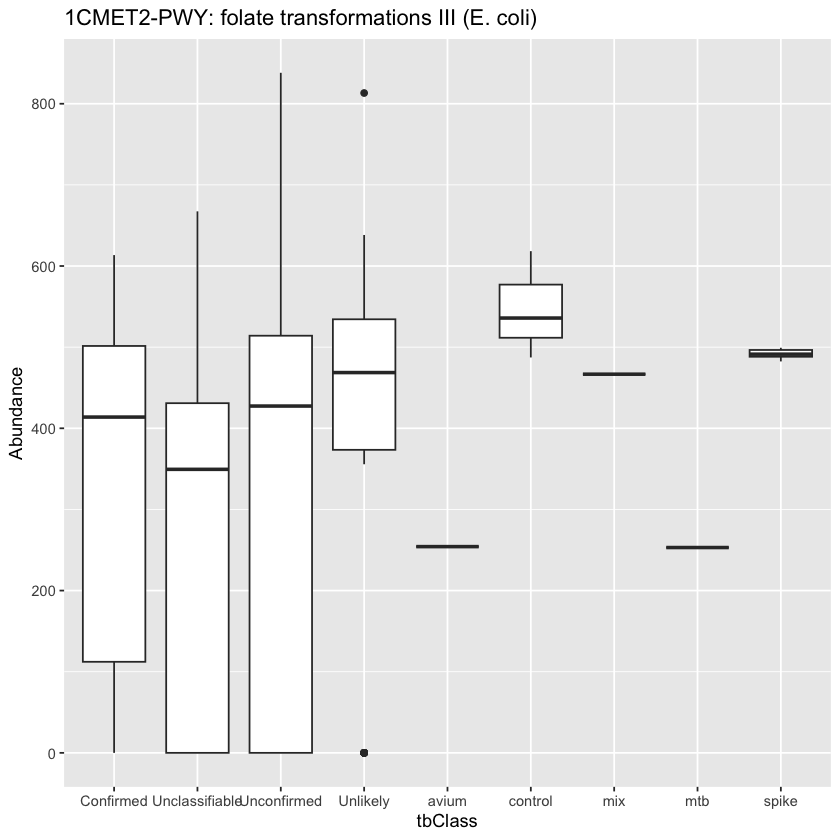

In [44]:
library(ggplot2)
feature_name <- "1CMET2-PWY: folate transformations III (E. coli)"
feature_values <- cross_taxa[feature_name, ]
df <- data.frame(
  value = as.numeric(feature_values),
  tbClass = meta$tbClass
)
ggplot(df, aes(x = tbClass, y = value)) +
  geom_boxplot() +
  labs(title = feature_name, x = "tbClass", y = "Abundance")
